
## About the Data
For the analysis presented in this report, the following definitions are used:
• COVID deaths = claims with primary cause of death reported as COVID-19
• Non-COVID deaths = claims with primary cause of death known, but not reported as COVID-19
• Unknown deaths = claims where primary cause of death was not reported by the insurer

“All-Cause” death claims include all three categories listed, whereas “known COD” death claims exclude the “unknown deaths.”


## Questions to be Answered:

1> Overall Claims Analysis

2> Check which underwriting class has more covid deaths

3> Check which states were badly hit by covid deaths

4> Check the % of retro vs assumed and the sum of amount

5> Monthwise analysis of covid death in 2021

6> Compare the covid year 2021 with previous years 2018,2019 and 2020

7>Average Age and Claims by Attained Age and Sex Analysis

8>Claims by Geographic Region Analysis

9>Claims by Underwriting Class and Smoker Status Analysis

10>Claims by Face Amount Analysis

11>Claims by Cause of Death Analysis

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
from functools import reduce

import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

### Read and Understand data

In [2]:
claims=pd.read_csv(r'/kaggle/input/covid-analysis/dat2.csv')
df=claims.copy()

In [3]:
#convert datetime column to just date 
df[['BIRTHDATE','DOD','SETUP_DATE']] = df[['BIRTHDATE','DOD','SETUP_DATE']].apply(pd.to_datetime)

In [4]:
df.head()

,COUNT(C.CLAIMID),UWCLASS,SEX,BIRTHDATE,DOD,ISSAGE,ASMDRETRO,STATERES,CAUSEOFDTH,SETUP_DATE,REQAMT
0,1.0,N,M,1925-07-18,2019-06-16,61.0,A,KS,CVD,2019-10-17,11914
1,1.0,N,M,1925-07-18,2019-06-16,61.0,A,KS,CVD,2019-10-17,154689
2,1.0,N,M,1946-07-03,2021-07-23,49.0,R,MN,UNK,2021-08-09,86462
3,1.0,NP,M,1937-11-10,2021-04-02,65.0,A,IN,NaN,2021-07-09,453546
4,1.0,N,M,1926-11-18,2019-11-30,60.0,A,MI,CVD,2020-01-07,866


In [5]:
#data description
print(df.shape)
print(df.describe())
print(df.info())

(509771, 11)
       COUNT(C.CLAIMID)         ISSAGE
count     508212.000000  508212.000000
mean           1.000214      53.600720
std            0.014643      15.096046
min            1.000000       0.000000
25%            1.000000      43.000000
50%            1.000000      54.000000
75%            1.000000      65.000000
max            2.000000      98.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509771 entries, 0 to 509770
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   COUNT(C.CLAIMID)  508212 non-null  float64       
 1   UWCLASS           507945 non-null  object        
 2   SEX               507956 non-null  object        
 3   BIRTHDATE         508212 non-null  datetime64[ns]
 4   DOD               494480 non-null  datetime64[ns]
 5   ISSAGE            508212 non-null  float64       
 6   ASMDRETRO         508212 non-null  object        
 7   STATERES          486751 

In [6]:
#checking the null value
df.isnull().sum()


COUNT(C.CLAIMID)     1559
UWCLASS              1826
SEX                  1815
BIRTHDATE            1559
DOD                 15291
ISSAGE               1559
ASMDRETRO            1559
STATERES            23020
CAUSEOFDTH          95928
SETUP_DATE           1559
 REQAMT              7786
dtype: int64

1>We have a lot of missing values  that needs to be dropped or filled

2>We have 5 cateogrical values UWCLASS,SEX,ASMDRETRO,STATERES,CAUSEOFDTH

3> Quantative values Issage :Issue age and Reqamt

4> we have 3 date columns ,which needs to be used to extract useful information such as Age at death and month and year from setup date 

In [7]:
#changing object dtype to category  to save memory
df.UWCLASS=df['UWCLASS'].astype("category")
df.SEX=df['SEX'].astype("category")
df.ASMDRTRO=df['ASMDRETRO'].astype("category")
df.STATERES=df['STATERES'].astype("category")
df.CAUSEOFDTH=df['CAUSEOFDTH'].astype("category")

In [8]:
#and extract Age and month,year from setup date 
df1=df.copy()
#Extract age
df1['age']=(df1['DOD'].dt.year-df1['BIRTHDATE'].dt.year)
#Extracting month from Setup date
df1['month']=df1['SETUP_DATE'].dt.month
#Extracting Year from Setup date
df1['year']=df1['SETUP_DATE'].dt.year
#dropping the Date columns
df1.drop(columns=['BIRTHDATE','DOD','SETUP_DATE'],inplace=True)

In [9]:
df1.head()

,COUNT(C.CLAIMID),UWCLASS,SEX,ISSAGE,ASMDRETRO,STATERES,CAUSEOFDTH,REQAMT,age,month,year
0,1.0,N,M,61.0,A,KS,CVD,11914,94.0,10.0,2019.0
1,1.0,N,M,61.0,A,KS,CVD,154689,94.0,10.0,2019.0
2,1.0,N,M,49.0,R,MN,UNK,86462,75.0,8.0,2021.0
3,1.0,NP,M,65.0,A,IN,NaN,453546,84.0,7.0,2021.0
4,1.0,N,M,60.0,A,MI,CVD,866,93.0,1.0,2020.0


CAUSEOFDEATH description:

ALC	Alcoholism/Drug Overdose
ALZ	Alzheimer's 
ARC	Aids Related Causes
AT	Asian Tsunami
AVI	Aviation dth-passngr
AVP	Aviation dth-pilot
CA	Cancer
COV	COVID-19
CVD	Cardio Vascular Disease
DEM	Dementia
DIA	Diabetes
HN	H1N1 Virus - Swine Flu
HOM	Homicide
HUR	Hurricane
LVR	Liver Failure
MVA	Motor Vehicle Accident
N/A	Not Available
NAT	Natural
NEW	Chk Accrual
OA	Other Accident
OD	Other Disease
PNU	Pneumonia
PUL	Pulmonary 
REN	Renal (Kidney) Failure
STK	Stroke
SUI	Suicide

In [10]:
df1.UWCLASS.value_counts()

NN    122610
N     117675
NP     75838
A      64912
S      38849
NV     31289
NE     22920
SN     15831
P       8924
SP      7981
T        446
SV       399
TV       100
TN        79
TP        33
C         30
N1        25
N2         3
N3         1
Name: UWCLASS, dtype: int64

UWCLASS description:

A	Aggregate  Class:  13
C	Combined(NS/SM) Class: 18
N	Nonsmoker  Class:  9
N1	NONSMOKER SYNDICATE 1 - AUSTRALIAN 4
N2	NONSMOKER SYNDICATE 2 - AUSTRALIAN 5
N3	NONSMOKER SYNDICATE 3 - AUSTRALIAN 6
N4	NONSMOKER SYNDICATE 4 - AUSTRALIAN 7
N5	NONSMOKER SYNDICATE 5 - AUSTRALIAN 8
NE	Ex-Smoker  Class:  11
NN	Non-smoker Non-Preferred  Class:  10
NP	Nonsmoker Preferred  Class:  2
NV	Never Smoked  Class:  1
P	Preferred  Class:  3
RN	Rated NonSmoker  Class:  12
S	Smoker  Class:  26
S1	SMOKER SYNDICATE 1 - AUSTRALIAN 21
S2	SMOKER SYNDICATE 2 - AUSTRALIAN 22
S3	SMOKER SYNDICATE 3 - AUSTRALIAN 23
S4	SMOKER SYNDICATE 4 - AUSTRALIAN 24
S5	SMOKER SYNDICATE 5 - AUSTRALIAN 25
SN	Smoker Non-Preferred  Class:  27
SP	Smoker Preferred  Class:  20
SV	Super-Preferred SM: 19
T	Tobacco Use Only (Pipe or Cigar) Class: 16
TN	Non-Preferred Tobacco: 17
TP	Preferred Tobacco: 15
TV	Super-Preferred Tobacco: 14


## Cleaning the data

In [11]:
df1.describe(include='category')

,UWCLASS,SEX,STATERES,CAUSEOFDTH
count,507945,507956,486751,413843
unique,19,3,120,25
top,NN,M,CA,CA
freq,122610,322086,48314,102792


There are 120 stateres value,in this analysis we are going to only check the data for all 50 states of USA

In [12]:
#All the 50 states of USA
states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}

In [13]:
df1.shape
#states.keys()

(509771, 11)

In [14]:
#filtering out  the records which does not belong to USA
df2=df1.copy()
df2 = df2[df2['STATERES'].isin(states.keys())]
df2.shape

(484881, 11)

In [15]:
#Creating a new column for Underwriting Class and Smoker Status Analysis
#we can split the entire UWCLASS column into 4 groups 
#Preferred,Standard,Aggregate,Substandard
# class_dict={'Preferred': ['NV','NP','P','TV','TP','SV','SP'],
#              'Standard': ['N','NE','RN'],
#              'Aggregate': ['A','C'],
#              'Substandard': ['NN','T','TN','S','SN']}

dict={('NV','NP','P','TV','TP','SV','SP'): 'Preferred',('N','NE','RN'):'Standard',('A','C'):'Aggregate',('NN','T','TN','S','SN'):'Substandard'}
#remove anything 1ith N1,N2 and N3

df2=df2[~df2['UWCLASS'].isin(['N1','N2','N3'])]

In [16]:
df2.replace({"UWCLASS": dict},inplace=True)

In [17]:
df2.head()

,COUNT(C.CLAIMID),UWCLASS,SEX,ISSAGE,ASMDRETRO,STATERES,CAUSEOFDTH,REQAMT,age,month,year
0,1.0,Standard,M,61.0,A,KS,CVD,11914,94.0,10.0,2019.0
1,1.0,Standard,M,61.0,A,KS,CVD,154689,94.0,10.0,2019.0
2,1.0,Standard,M,49.0,R,MN,UNK,86462,75.0,8.0,2021.0
3,1.0,Preferred,M,65.0,A,IN,NaN,453546,84.0,7.0,2021.0
4,1.0,Standard,M,60.0,A,MI,CVD,866,93.0,1.0,2020.0


In [18]:
#creating acolumn for grouping the age
df2['age_bins'] = pd.cut(x=df2['age'], bins=[20, 29, 39, 49,59,69,79,89,99])


In [19]:
df2.head()

,COUNT(C.CLAIMID),UWCLASS,SEX,ISSAGE,ASMDRETRO,STATERES,CAUSEOFDTH,REQAMT,age,month,year,age_bins
0,1.0,Standard,M,61.0,A,KS,CVD,11914,94.0,10.0,2019.0,"(89, 99]"
1,1.0,Standard,M,61.0,A,KS,CVD,154689,94.0,10.0,2019.0,"(89, 99]"
2,1.0,Standard,M,49.0,R,MN,UNK,86462,75.0,8.0,2021.0,"(69, 79]"
3,1.0,Preferred,M,65.0,A,IN,NaN,453546,84.0,7.0,2021.0,"(79, 89]"
4,1.0,Standard,M,60.0,A,MI,CVD,866,93.0,1.0,2020.0,"(89, 99]"


## Claims by Underwriting Class and Smoker Status Analysis

<AxesSubplot:xlabel='UWCLASS', ylabel='count'>

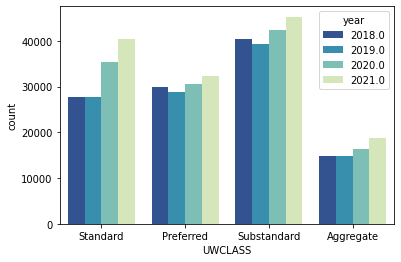

In [20]:
#checking the count of death for UW in years
import seaborn as sns
df3=df2.copy()
#df3_2021=df3[df3.year==2021]
sns.countplot(x=df3.UWCLASS,hue=df3.year,palette='YlGnBu_r')


[Text(0.5, 1.0, '2020')]

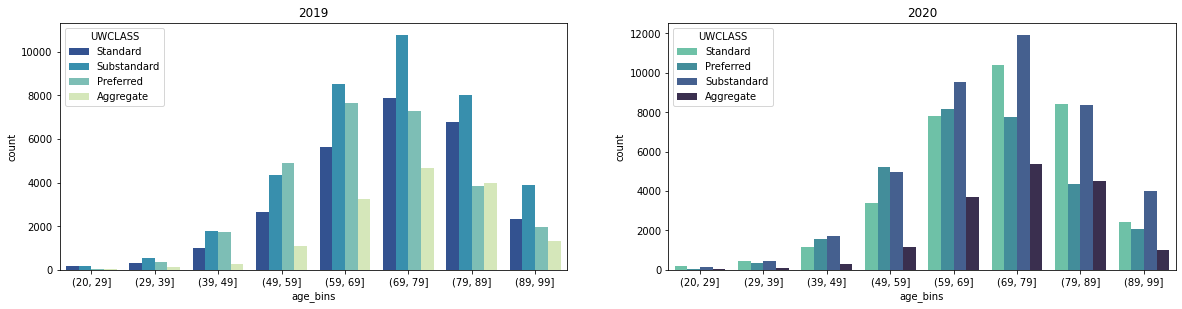

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
df3_2020=df3[(df3.year==2019)]
sns.countplot(x=df3_2020.age_bins,hue=df3_2020.UWCLASS,palette='YlGnBu_r').set(title=2019)
plt.subplot(2,2,2)
df3_2021=df3[df3.year==2020]
sns.countplot(x=df3_2021.age_bins,hue=df3_2021.UWCLASS,palette='mako_r').set(title=2020)

### INSURED CLAIMS IN COD ANALYSIS - COVID VERSUS NON-COVID, JANUARY 2020 - JUNE 20201

[Text(0.5, 1.0, '2020/2021_noncov')]

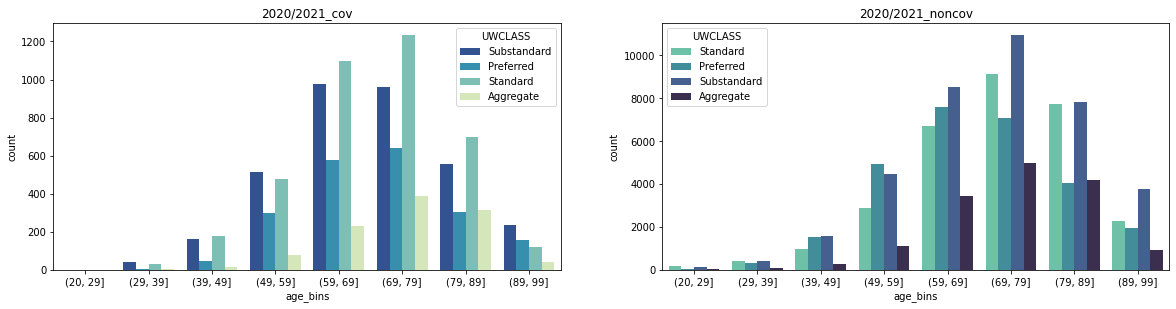

In [22]:
#cleaning the data to keep only the records which are from USA
df3=df2.copy()
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
df3_2020_cov=df3[(df3['year'].isin([2020])) & (df3.CAUSEOFDTH=="COV")]
sns.countplot(x=df3_2020_cov.age_bins,hue=df3_2020_cov.UWCLASS,palette='YlGnBu_r').set(title="2020/2021_cov")
plt.subplot(2,2,2)
df3_2020_non_cov=df3[(df3['year'].isin([2020])) & (df3.CAUSEOFDTH!="COV")]
sns.countplot(x=df3_2020_non_cov.age_bins,hue=df3_2020_non_cov.UWCLASS,palette='mako_r').set(title="2020/2021_noncov")

In [23]:
#%of covid claim  against total claims in 2020
np.round((df3_2020_non_cov['COUNT(C.CLAIMID)'].sum())/(df3_2020_cov['COUNT(C.CLAIMID)'].sum()),2)

10.96

In [24]:
#DISTRIBUTION OF ALL-CAUSE U.S. DEATHS BY GEOGRAPHIC REGION, JANUARY 2020 - JUNE 2020
#https://medium.com/@erikgreenj/mapping-us-states-with-geopandas-made-simple-d7b6e66fa20d
df4=df3.copy()

#https://towardsdatascience.com/choropleth-maps-101-using-plotly-5daf85e7275d

In [25]:
df3_cov=df3[(df3['year'].isin([2020,2021])) & (df3.CAUSEOFDTH=="COV")]
df3_noncov=df3[(df3['year'].isin([2020,2021])) & (df3.CAUSEOFDTH!="COV")]
df3_cov.head()

,COUNT(C.CLAIMID),UWCLASS,SEX,ISSAGE,ASMDRETRO,STATERES,CAUSEOFDTH,REQAMT,age,month,year,age_bins
57,1.0,Substandard,M,74.0,A,IA,COV,36338,79.0,12.0,2020.0,"(69, 79]"
88,1.0,Preferred,M,72.0,A,MN,COV,1420448,92.0,4.0,2020.0,"(89, 99]"
102,1.0,Preferred,M,55.0,A,TX,COV,1050000,84.0,8.0,2021.0,"(79, 89]"
129,1.0,Substandard,M,53.0,A,IL,COV,95497,83.0,11.0,2020.0,"(79, 89]"
141,1.0,Standard,M,38.0,A,NM,COV,37261,74.0,4.0,2021.0,"(69, 79]"


In [26]:
# fig = px.choropleth(locations=df4["STATERES"],
#                     color=df4["STATERES"], 
#                     locationmode="USA-states",
#                     scope="usa",
#                     #animation_frame=df4["year"],
#                     color_continuous_scale='Reds',
#                     range_color=[0,600000]
#                     #autocolorscale=False,
#                    )
# fig

Choropleth
https://github.com/gokulcharade/covid19/blob/master/mapping.py

In [27]:
 df3_cov=df3_cov.dropna()

In [28]:
fig = px.choropleth(data_frame = df3_cov,
                    locations= "STATERES",
                    locationmode="USA-states",
                    color= 'COUNT(C.CLAIMID)',
                    scope="usa",
                    hover_name= "STATERES",
                    color_continuous_scale= 'Reds'
                    )
fig.show()

In [29]:
#shows %adherents at state level for the year 2010
# #shows %adherents at state level for the year 2010
# fig1 = px.choropleth(locations=df3_cov["STATERES"], locationmode="USA-states",
#  color=df3_cov['REQAMT'],color_continuous_scale="inferno",
#  range_color=(0, 100),scope="usa")
#  #hover_data={df3_cov["STATERES"]:False})
# fig1.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# #fig1.show()